In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../data/.DS_Store
../data/american_sign_language.PNG
../data/sign_mnist_test.csv
../data/sign_mnist_train.csv
../data/amer_sign3.png
../data/amer_sign2.png
../data/sign_mnist_train/sign_mnist_train.csv
../data/sign_mnist_test/sign_mnist_test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

2023-03-21 15:56:46.334383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_df = pd.read_csv("../data/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("../data/sign_mnist_test/sign_mnist_test.csv")

In [4]:
test = pd.read_csv("../data/sign_mnist_test/sign_mnist_test.csv")
y = test['label']
y.shape

(7172,)

In [5]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


<Axes: xlabel='label', ylabel='count'>

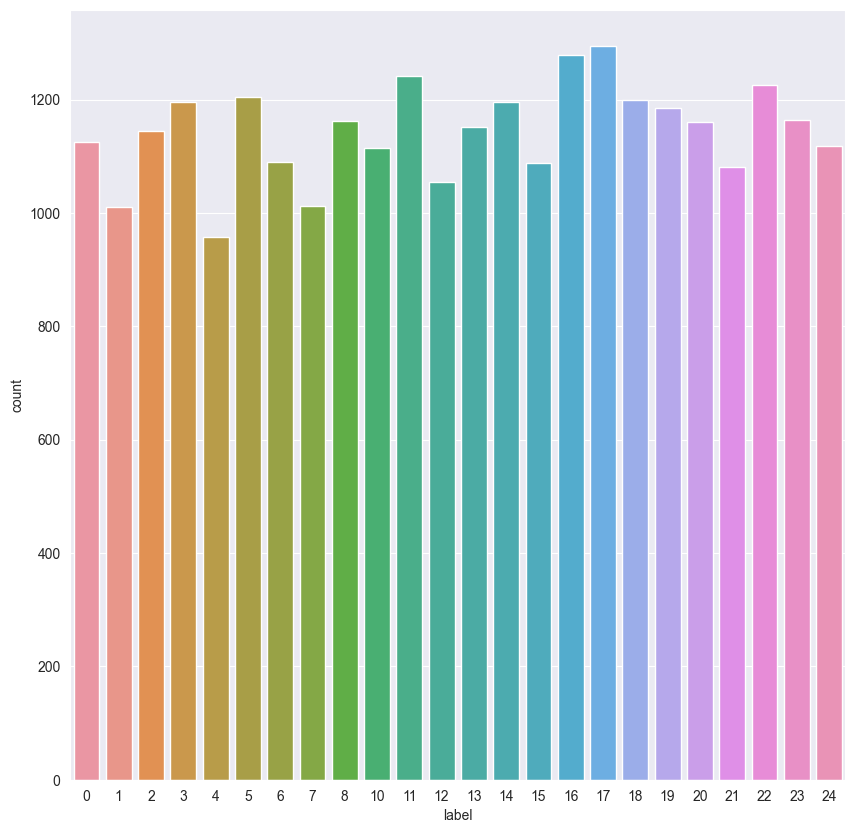

In [6]:
plt.figure(figsize=(10, 10))
sns.set_style("darkgrid")
# Plot the countplot with the ordered categories
label_series = pd.Series(train_df['label'])
sns.countplot(x=label_series)

In [7]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [8]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [9]:
x_train = train_df.values
x_test = test_df.values

In [10]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [11]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

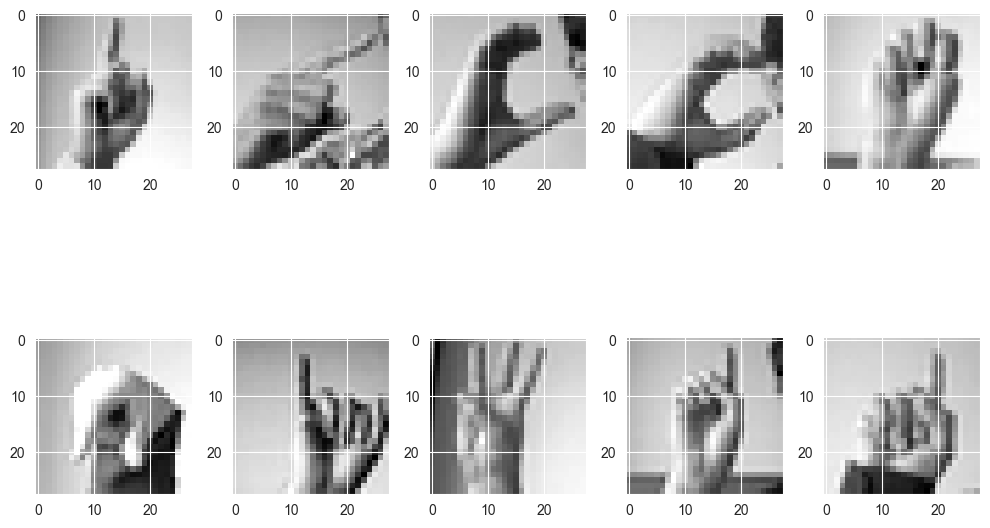

In [12]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

In [13]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [15]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

2023-03-21 15:56:56.532703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 37s 166ms/step - loss: 1.0475 - accuracy: 0.6718 - val_loss: 3.6084 - val_accuracy: 0.2059 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 35s 162ms/step - loss: 0.2177 - accuracy: 0.9292 - val_loss: 1.3812 - val_accuracy: 0.5756 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 35s 164ms/step - loss: 0.1034 - accuracy: 0.9661 - val_loss: 0.4458 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 35s 163ms/step - loss: 0.0700 - accuracy: 0.9771 - val_loss: 0.0617 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 35s 164ms/step - loss: 0.0492 - accuracy: 0.9839 - val_loss: 0.3642 - val_accuracy: 0.8949 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 35s 161ms/step - loss: 0.0354 - accuracy: 0.9891 - val_loss: 0.0100 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 7/20
215/215 [==============================] 

In [17]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 3s 12ms/step - loss: 5.0082e-04 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


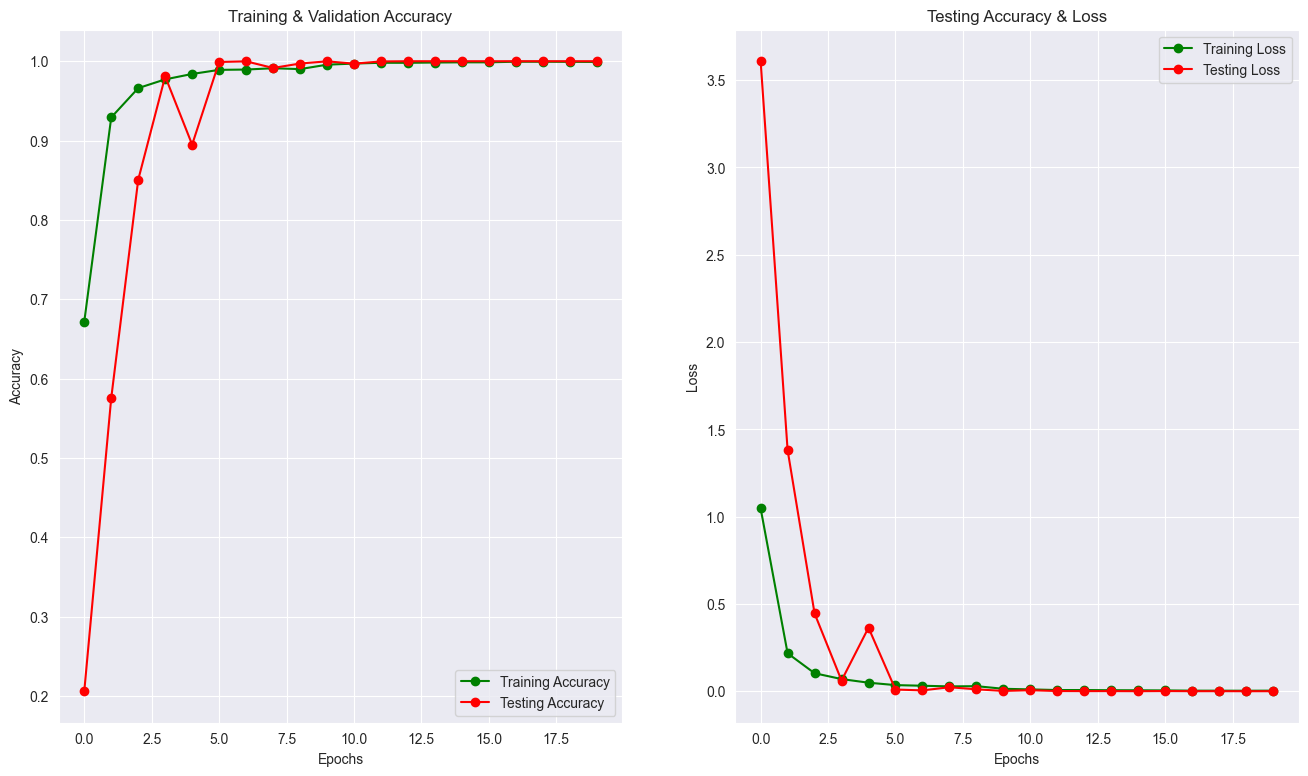

In [18]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [19]:
x_test.shape

(7172, 28, 28, 1)

In [20]:
# Obtain model predictions
predictions = model.predict(x_test)

# Get the class labels with highest probability
predicted_labels = np.argmax(predictions, axis=1)

# Adjust predicted labels
for i in range(len(predicted_labels)):
    if predicted_labels[i] >= 9:
        predicted_labels[i] += 1

225/225 [==============================] - 3s 12ms/step


In [21]:
predictions.shape

(7172, 24)

In [22]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
classes

['Class 0',
 'Class 1',
 'Class 2',
 'Class 3',
 'Class 4',
 'Class 5',
 'Class 6',
 'Class 7',
 'Class 8',
 'Class 10',
 'Class 11',
 'Class 12',
 'Class 13',
 'Class 14',
 'Class 15',
 'Class 16',
 'Class 17',
 'Class 18',
 'Class 19',
 'Class 20',
 'Class 21',
 'Class 22',
 'Class 23',
 'Class 24']

In [23]:
x_test.shape

(7172, 28, 28, 1)

In [24]:
predictions

array([[8.1078312e-14, 6.0603335e-11, 5.2445568e-09, ..., 6.5581055e-16,
        1.6841704e-09, 1.0352569e-12],
       [3.9031316e-11, 8.6995965e-07, 6.0065363e-17, ..., 2.5496428e-07,
        1.2836411e-16, 5.8190714e-09],
       [6.8796463e-20, 6.6643014e-18, 5.5788150e-20, ..., 6.8956817e-14,
        1.3000082e-16, 4.3043565e-14],
       ...,
       [1.6061679e-13, 3.8204426e-15, 9.9999988e-01, ..., 1.5949592e-19,
        6.1380428e-16, 2.7224102e-16],
       [2.2205108e-11, 2.2647500e-12, 4.2316181e-16, ..., 3.8663836e-19,
        2.8684737e-14, 1.4574459e-16],
       [2.6719133e-13, 4.1979186e-16, 1.0000000e+00, ..., 1.7125194e-19,
        1.9825706e-16, 9.3757293e-16]], dtype=float32)

In [25]:
y_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [26]:
predictions

array([[8.1078312e-14, 6.0603335e-11, 5.2445568e-09, ..., 6.5581055e-16,
        1.6841704e-09, 1.0352569e-12],
       [3.9031316e-11, 8.6995965e-07, 6.0065363e-17, ..., 2.5496428e-07,
        1.2836411e-16, 5.8190714e-09],
       [6.8796463e-20, 6.6643014e-18, 5.5788150e-20, ..., 6.8956817e-14,
        1.3000082e-16, 4.3043565e-14],
       ...,
       [1.6061679e-13, 3.8204426e-15, 9.9999988e-01, ..., 1.5949592e-19,
        6.1380428e-16, 2.7224102e-16],
       [2.2205108e-11, 2.2647500e-12, 4.2316181e-16, ..., 3.8663836e-19,
        2.8684737e-14, 1.4574459e-16],
       [2.6719133e-13, 4.1979186e-16, 1.0000000e+00, ..., 1.7125194e-19,
        1.9825706e-16, 9.3757293e-16]], dtype=float32)

In [27]:
predictions.size

172128

In [28]:
predictions.shape

(7172, 24)

In [29]:
y_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [30]:
y_test.shape

(7172, 24)

In [31]:
y_test.size

172128

In [32]:
rounded_predictions = np.round(predictions)

In [33]:
rounded_predictions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [34]:
print(classification_report(y_test, rounded_predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [35]:
y_test_single = np.argmax(y_test, axis=1)
rounded_predictions_single = np.argmax(rounded_predictions, axis=1)
cm = confusion_matrix(y_test_single, rounded_predictions_single)


<Axes: >

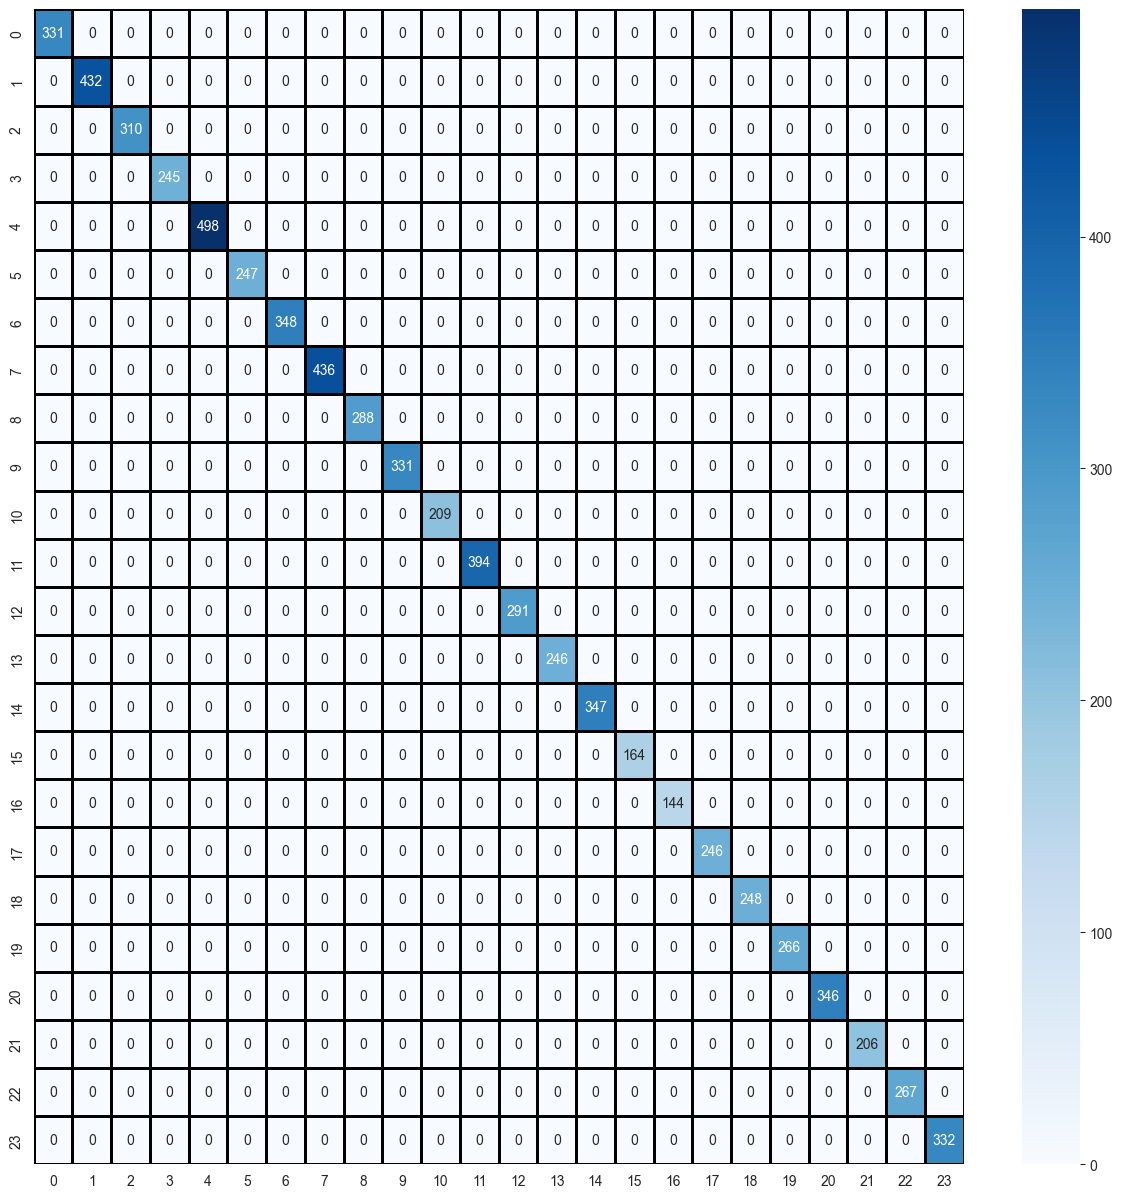

In [36]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [37]:
correct = np.nonzero(rounded_predictions == y_test)[0]
correct

array([   0,    0,    0, ..., 7171, 7171, 7171])

/var/folders/53/tqvs85rx65l9w65h088fbd_m0000gn/T/ipykernel_47624/4252056354.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


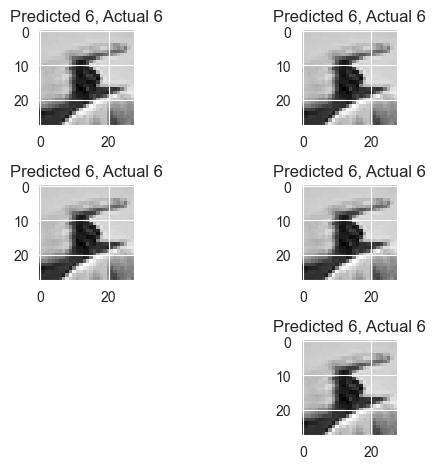

In [44]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted {}, Actual {}".format(rounded_predictions[c].argmax(), y_test[c].argmax()))
    plt.tight_layout()
    i += 1
